In [37]:
import numpy as np
import matplotlib.pyplot as plt
import Gadget_pack.units as unt
import pandas as pd

In [38]:
acc_data = !ls ../acc_duomenys/
acc_data=acc_data[1:]
acc_data;

In [39]:
f = open('../acc_duomenys/acc_data_help.txt','r')
for line in f:
    print(line.strip())
f.close()

fulldata[0,:] = time_list # codeunits
fulldata[1,:] = mtot # g
fulldata[2,:] = dm_dt # g/s
fulldata[3,:] = Etot # erg
fulldata[4,:] = Ld # erg/s
fulldata[5,:] = Ld/Le # Eddingtons units


In [40]:
#laikas istikro kazkodel sekundem o ne kodo vienetais
t = np.loadtxt("../acc_duomenys/" + acc_data[0])[0,:]
t / unt.yr_in_s;# * unt.UnitTime_in_s / unt.yr_in_s
t = np.array(t)

In [44]:

def get_total_mass(acc_data):
    mtot = np.zeros(len(acc_data))
    for i in range(len(acc_data)):
        m = np.loadtxt("../acc_duomenys/"+acc_data[i])
        mtot[i] = m[1,-1]
    return mtot
    

In [45]:
mt = get_total_mass(acc_data)
#mtang = mt.copy().reshape(12,4)
angle = np.arange(0,181,15)
#anglesn = (np.ones(4)[np.newaxis,:]*angle[angle!=165, np.newaxis]).T

In [3]:
mtang = np.load("total_acc_mass.npy")

<IPython.core.display.Javascript object>


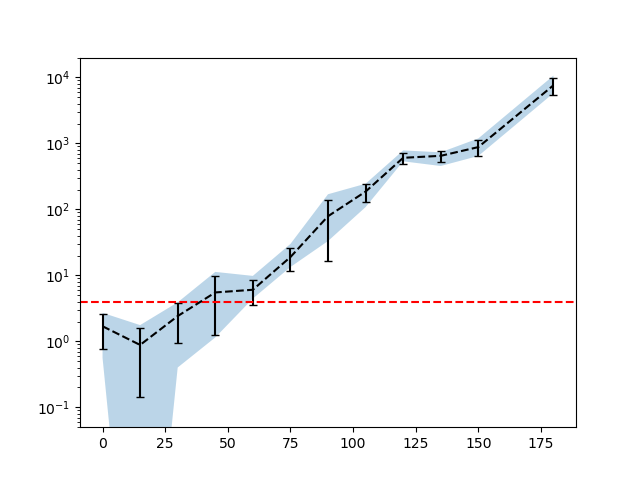

In [23]:
A = mtang.std(axis=1, ddof=1)
B = mtang.mean(axis=1)
plt.errorbar(angle[angle!=165], B / unt.M_s, yerr=A / unt.M_s, color='k',\
             linestyle='--',capsize=3)
plt.yscale('log')
#plt.plot(anglesn, mtang / unt.M_s)
plt.ylim(0.5e-1, 2e4)

MAX = mtang.max(axis=1)
MIN = mtang.min(axis=1)
plt.fill_between(angle[angle!=165], MIN / unt.M_s, MAX / unt.M_s, alpha=0.3)
plt.axhline(y=4, linestyle='--',color='r')
#plt.xlim(r'$\gamma$')
#plt.ylim(r'M$_s$')

In [10]:
data = pd.DataFrame(mtang, index=angle[angle!=165])
data

,0,1,2,3
0,1.117025e+33,4.103706e+33,2.870526e+33,5.384224e+33
15,2.220646e+27,3.507802e+33,1.358091e+33,2.156078e+33
30,7.987852e+32,5.355981e+33,5.309040e+33,7.769035e+33
45,2.280192e+33,2.247411e+34,1.078754e+34,8.334707e+33
60,8.860598e+33,9.792246e+33,1.954511e+34,9.972449e+33
75,3.046671e+34,5.958845e+34,3.416147e+34,2.663709e+34
90,3.377246e+35,8.654457e+34,1.370994e+35,6.592143e+34
105,4.133727e+35,4.874466e+35,3.647428e+35,2.156092e+35
120,1.087150e+36,1.065461e+36,1.558993e+36,1.106081e+36
135,1.459556e+36,1.398241e+36,1.401003e+36,9.051502e+35


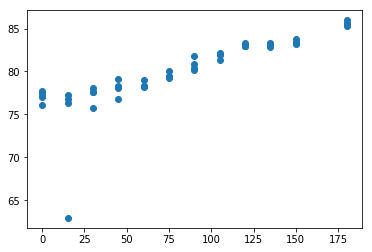

In [27]:
plt.scatter((np.ones(4)[:,np.newaxis]*angle[angle!=165]).T, np.log(mtang))


In [161]:
y_new =  mt.copy()
y_new
x_new = angle[angle!=165]
p = (x_new*np.ones(4)[:,np.newaxis]).T
p

array([[  0.,   0.,   0.,   0.],
       [ 15.,  15.,  15.,  15.],
       [ 30.,  30.,  30.,  30.],
       [ 45.,  45.,  45.,  45.],
       [ 60.,  60.,  60.,  60.],
       [ 75.,  75.,  75.,  75.],
       [ 90.,  90.,  90.,  90.],
       [105., 105., 105., 105.],
       [120., 120., 120., 120.],
       [135., 135., 135., 135.],
       [150., 150., 150., 150.],
       [180., 180., 180., 180.]])

In [162]:
x_new = p.reshape(len(y_new))
y_new = np.log(y_new)

print(x_new.shape)
print(y_new.shape)
paklaida = (mtang.std(axis=1)*np.ones(4)[:,np.newaxis]).T.reshape(np.size(mtang))
print(paklaida.shape)
#plt.scatter(x_new, np.log(y_new))
x_new = x_new[8:]
y_new = y_new[8:]
paklaida = paklaida[8:]

(48,)
(48,)
(48,)


(40, 2)
(40, 40)


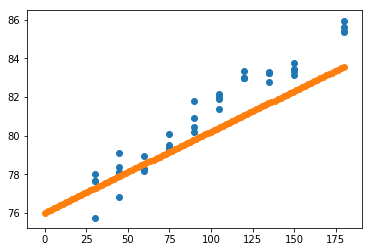

In [164]:
A = np.vstack((np.ones_like(x_new), x_new)).T
C = (paklaida * paklaida)*np.eye(len(paklaida), len(paklaida))
print(A.shape)
print(C.shape)

cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y_new)))


xs = np.linspace(0,180,100)
ys = m_ls*xs + b_ls
plt.scatter(x_new, y_new)
plt.scatter(xs, ys)

In [165]:
def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [170]:
import scipy.optimize as op
f_true = 0.5
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_ls, b_ls, np.log(f_true)], args=(x_new, y_new, paklaida))
m_ml, b_ml, lnf_ml = result["x"]

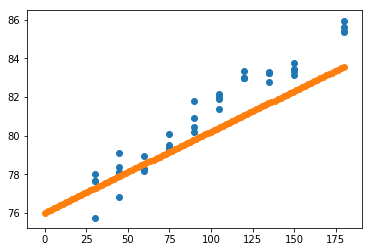

In [174]:
xs = np.linspace(0,180,100)
ys = m_ml*xs + b_ml
plt.scatter(x_new, y_new)
plt.scatter(xs, ys)

In [175]:
def lnprior(theta):
    m, b, lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

In [176]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [177]:
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [179]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x_new, y_new, paklaida))

In [181]:
sampler.run_mcmc(pos, 500)

/home/s_matas/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/s_matas/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


(array([[ 4.18474860e-02,  7.60217850e+01, -6.93193132e-01],
        [ 4.19570247e-02,  7.60218087e+01, -6.93206755e-01],
        [ 4.18120897e-02,  7.60216892e+01, -6.93207272e-01],
        [ 4.18300876e-02,  7.60219191e+01, -6.93092320e-01],
        [ 4.19396792e-02,  7.60217657e+01, -6.93179387e-01],
        [ 4.19253800e-02,  7.60217047e+01, -6.93018489e-01],
        [ 4.18971415e-02,  7.60217916e+01, -6.93172120e-01],
        [ 4.19292058e-02,  7.60216309e+01, -6.92995322e-01],
        [ 4.18444622e-02,  7.60217894e+01, -6.93051023e-01],
        [ 4.19001193e-02,  7.60216375e+01, -6.93058508e-01],
        [ 4.18781405e-02,  7.60216457e+01, -6.93120748e-01],
        [ 4.19047381e-02,  7.60216873e+01, -6.93085159e-01],
        [ 4.19222340e-02,  7.60215344e+01, -6.93142239e-01],
        [ 4.20332648e-02,  7.60217006e+01, -6.93204702e-01],
        [ 4.20138826e-02,  7.60215748e+01, -6.93058916e-01],
        [ 4.17687323e-02,  7.60217106e+01, -6.92993620e-01],
        [ 4.19488547e-02

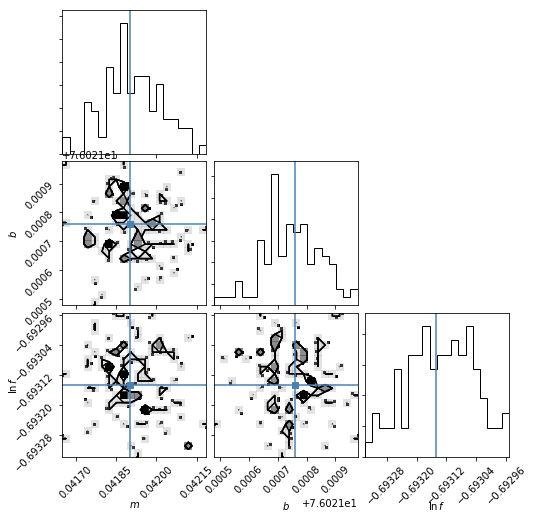

In [185]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
import corner
fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"],
                      truths=[m_ls, b_ls, np.log(f_true)])
fig.savefig("triangle.png")

<ErrorbarContainer object of 3 artists>

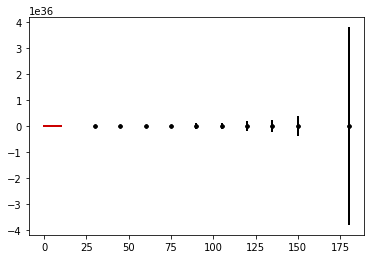

In [192]:
import matplotlib.pyplot as pl
xl = np.array([0, 10])

for m, b, lnf in samples[np.random.randint(len(samples), size=100)]:
    pl.plot(xl, m*xl+b, color="k", alpha=0.1)
    
pl.plot(xl, m_ls*xl+b_ls, color="r", lw=2, alpha=0.8)

pl.errorbar(x_new, y_new, yerr=paklaida, fmt=".k")

In [191]:
samples[:, 2] = np.exp(samples[:, 2])
m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
print(m_mcmc)
print(b_mcmc)
print(f_mcmc)

(0.04189990411855393, 0.00011816450102985349, 8.693090833650219e-05)
(76.02174535950604, 9.619859983445167e-05, 8.288984436433111e-05)
(1.6487328348384018, 7.559254831379647e-05, 7.390893759318118e-05)


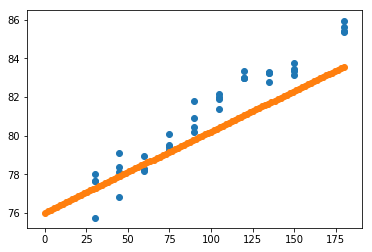

In [193]:
xs = np.linspace(0,180,100)
ys = m_mcmc[0]*xs + b_mcmc[0]
plt.scatter(x_new, y_new)
plt.scatter(xs, ys)